In [52]:
import torch.nn as nn
import torch

# Data-Augmentation

In [53]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

train_data_path = './Q3/train/'
test_data_path = './Q3/test/'


train_dataset = ImageFolder(root=train_data_path, transform=transform)
test_dataset = ImageFolder(root=test_data_path, transform=transform)



In [54]:
train_dataset.classes, train_dataset.class_to_idx

(['COVID', 'NORMAL'], {'COVID': 0, 'NORMAL': 1})

In [55]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


ordered_data_augmentation = []
ordered_data_augmentation.append([(image,label) for image, label in train_dataset])
ordered_data_augmentation.append([(transforms.functional.hflip(image),label) for image, label in train_dataset])

for angle in [90, 180, 270]:
    augmented_dataset = [(transforms.functional.rotate(image, angle=angle), label) for image, label in train_dataset]
    ordered_data_augmentation.append(augmented_dataset)



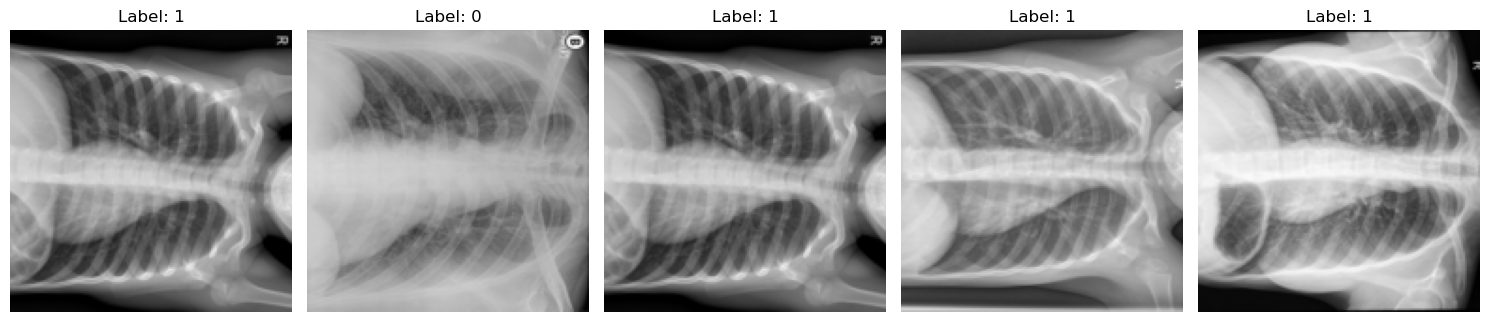

In [56]:
import matplotlib.pyplot as plt
import random


sample = random.choice(ordered_data_augmentation)

num_samples_to_display = 5
fig, axes = plt.subplots(1, num_samples_to_display, figsize=(15, 5))

for i in range(num_samples_to_display):
    index = random.randint(0, len(sample) - 1)
    image, label = sample[index]
    image = image.permute(1, 2, 0)


    axes[i].imshow(image)
    axes[i].set_title(f"Label: {label}")  
    axes[i].axis('off')  

plt.tight_layout()
plt.show()


In [57]:
# Check data shape and labels
for index, group in enumerate(ordered_data_augmentation):
    for data, label in group:
            if data.shape != torch.Size([3, 150, 150]) or type(label) != int:
                print(index)
                print(data)



# Model

In [58]:
import torch
device = "cuda" if torch.cuda.is_available else "cpu"
torch.set_default_device(device)
torch.manual_seed(42)

device

'cuda'

In [59]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self, gates, in_feature):
        super(CNN, self).__init__()
        self.gates = gates
        self.conv_1 = nn.Conv2d(3,64, 3, padding=1)
        self.conv_2 = nn.Conv2d(64,64, 3, padding=1)
        self.conv_3 = nn.Conv2d(64,128, 3, padding=1)
        self.conv_4 = nn.Conv2d(128,128, 3, padding=1)
        self.conv_5 = nn.Conv2d(128,256, 3, padding=1)
        self.conv_6 = nn.Conv2d(256,256, 3, padding=1)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(in_feature, 512)
        self.fc_2 = nn.Linear(512, 256)
        self.fc_3 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
        
        
        
        
    def down_sample(self, x):
        x = nn.MaxPool2d(2)(x)
        x = nn.BatchNorm2d(x.shape[1], affine=False)(x)
        x = nn.ReLU()(x)
        x = nn.Dropout(0.2)(x)
        
        return x
    
    def batch_norm(self, x):
        x =  nn.BatchNorm1d(x.shape[1], affine=False)(x)
        return nn.ReLU()(x)
    
    def conv(self, x):    
        x = self.conv_1(x)
        x = self.down_sample(x)
        
        if self.gates[0]:
            x = self.conv_2(x)
            x = self.down_sample(x)
        if self.gates[1]:
            x = self.conv_3(x)
            x = self.down_sample(x)
        if self.gates[2]:    
            x = self.conv_4(x)
            x = self.down_sample(x)
        if self.gates[3]:
            x = self.conv_5(x)
            x = self.down_sample(x)
        if self.gates[4]:     
            x = self.conv_6(x)
            x = self.down_sample(x)
            
        x = self.flatten(x)
        
        return x
    
    def classifier(self, x):
        x = self.fc_1(x)
        x = self.batch_norm(x)
        x = self.fc_2(x)
        x = self.batch_norm(x)
        x = self.fc_3(x)
        x = self.sigmoid(x)
        
        return x
    
    def forward(self, x):
        x = self.conv(x)
        x = self.classifier(x)
        
        return x

In [60]:
model = CNN([True for _ in range(5)], 1024).to(device).float()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
criterion = nn.BCELoss()

In [61]:
from torch.utils.data import Subset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

num_epochs = 10
metrics_train = {
    'train_accuracy': [],
    'val_accuracy': [],
    'train_loss': [],
    'val_loss': [],
}
generator = torch.Generator(device=device)

for index, augment in enumerate(ordered_data_augmentation):
    train_indices, valid_indices = train_test_split(list(range(len(augment))),
                                                    test_size=0.25)
    train_loader = DataLoader(Subset(augment, train_indices),
                              batch_size=20, shuffle=True,generator=generator)
    valid_loader = DataLoader(Subset( augment + ordered_data_augmentation, valid_indices),
                              batch_size=20,  shuffle=False,generator=generator)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0


        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted.float() == labels.float()).sum().item()
            

        train_accuracy = 100 * correct_train / total_train
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val

        epoch_loss = running_loss / len(train_loader)
        epoch_val_loss = val_loss / len(valid_loader)
        metrics_train['train_accuracy'].append(train_accuracy)
        metrics_train['val_accuracy'].append(val_accuracy)
        metrics_train['train_loss'].append(epoch_loss)
        metrics_train['val_loss'].append(epoch_val_loss)
        print(f"[data #{index+1}] Epoch [{epoch + 1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Val Loss: {epoch_val_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Val Acc: {val_accuracy:.2f}%")


[data #1] Epoch [1/10] - Loss: 0.5207 - Val Loss: 0.3700 - Train Acc: 51.35% - Val Acc: 45.95%
[data #1] Epoch [2/10] - Loss: 0.2841 - Val Loss: 0.2731 - Train Acc: 51.35% - Val Acc: 45.95%
[data #1] Epoch [3/10] - Loss: 0.1460 - Val Loss: 0.2730 - Train Acc: 51.35% - Val Acc: 45.95%
[data #1] Epoch [4/10] - Loss: 0.0739 - Val Loss: 0.1987 - Train Acc: 51.35% - Val Acc: 45.95%
[data #1] Epoch [5/10] - Loss: 0.0512 - Val Loss: 0.1768 - Train Acc: 51.35% - Val Acc: 45.95%
[data #1] Epoch [6/10] - Loss: 0.0565 - Val Loss: 0.1927 - Train Acc: 51.35% - Val Acc: 45.95%
[data #1] Epoch [7/10] - Loss: 0.0545 - Val Loss: 0.3003 - Train Acc: 51.35% - Val Acc: 45.95%
[data #1] Epoch [8/10] - Loss: 0.0319 - Val Loss: 0.1092 - Train Acc: 51.35% - Val Acc: 45.95%
[data #1] Epoch [9/10] - Loss: 0.0676 - Val Loss: 0.0986 - Train Acc: 51.35% - Val Acc: 45.95%
[data #1] Epoch [10/10] - Loss: 0.0550 - Val Loss: 0.2052 - Train Acc: 51.35% - Val Acc: 45.95%
[data #2] Epoch [1/10] - Loss: 0.1244 - Val Loss:

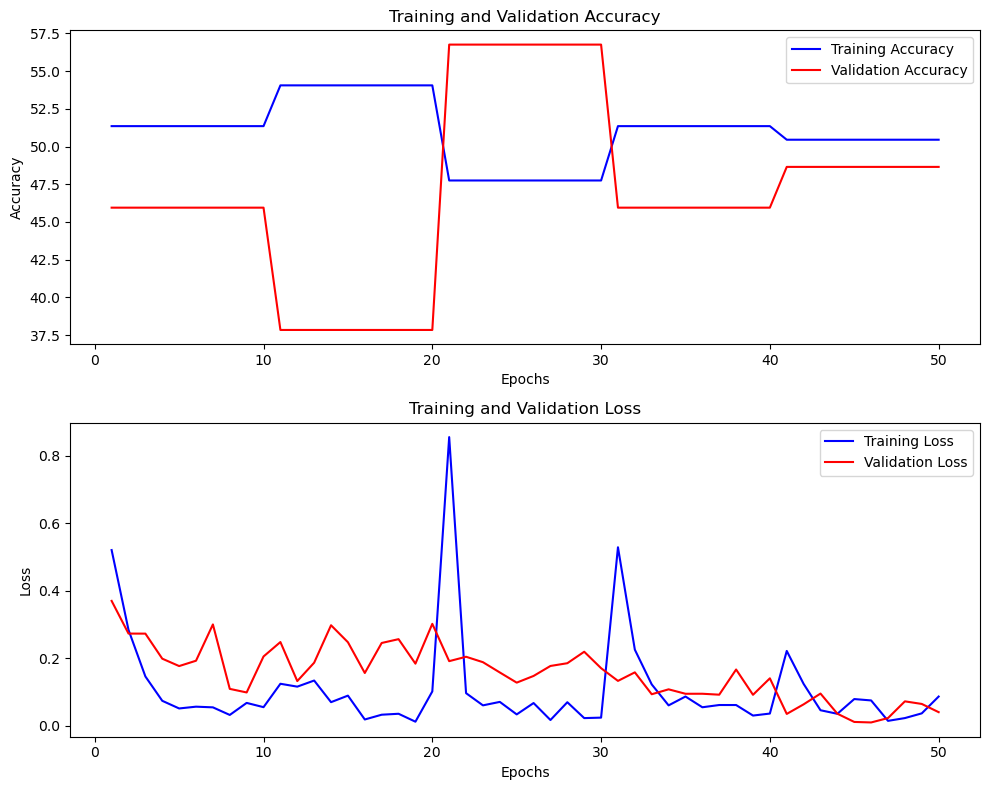

In [62]:
import matplotlib.pyplot as plt

train_accuracy = metrics_train['train_accuracy']
val_accuracy = metrics_train['val_accuracy']
train_loss = metrics_train['train_loss']
val_loss = metrics_train['val_loss']

epochs = range(1, len(train_accuracy) + 1)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
axes[0].plot(epochs, train_accuracy, 'b', label='Training Accuracy')
axes[0].plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[1].plot(epochs, train_loss, 'b', label='Training Loss')
axes[1].plot(epochs, val_loss, 'r', label='Validation Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


In [63]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

all_labels = []
all_predictions = []
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

f1 = f1_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, zero_division=1)
recall = recall_score(all_labels, all_predictions)
accuracy = accuracy_score(all_labels, all_predictions)

true_negatives, false_positives, false_negatives, true_positives = conf_matrix.ravel()

specificity = true_negatives / (true_negatives + false_positives)
sensitivity = true_positives / (true_positives + false_negatives)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall/Sensitivity: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")

F1 Score: 0.0000
Precision: 1.0000
Recall/Sensitivity: 0.0000
Accuracy: 0.5000
Specificity: 1.0000
Sensitivity: 0.0000


# Multi CNN

In [64]:
from torch.utils.data import Subset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

gates = [False, False, False, False, False]
in_features = [360000, 87616, 41472, 10368, 4096, 1024]

num_epochs = 10
metrics_train = {
    'test_acc': [],
    'val_acc': [],
}
generator = torch.Generator(device=device)
for i in range(len(gates)+1):
    cnn =  CNN(gates, in_features[i])
    if i < len(gates):   
       gates[i] = True 
    correct_val = 0
    total_val = 0
    correct_test = 0
    total_test = 0
    for index, augment in enumerate(ordered_data_augmentation):
        train_indices, valid_indices = train_test_split(list(range(len(augment))),
                                                        test_size=0.25)
        train_loader = DataLoader(Subset(augment, train_indices),
                                  batch_size=20, shuffle=True,generator=generator)
        valid_loader = DataLoader(Subset( augment + ordered_data_augmentation, valid_indices),
                                  batch_size=20,  shuffle=False,generator=generator)
        for epoch in range(num_epochs):
            model.train()

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())
                loss.backward()
                optimizer.step()


            model.eval()
            with torch.no_grad():
                for inputs, labels in valid_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    total_val += labels.size(0)
                    correct_val+= (predicted.float() == labels.float()).sum().item()
                    

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted.float() == labels.float()).sum().item()

    val_acc = 100 * correct_val/ total_val
    test_acc =  100 * correct_test / total_test
        
    metrics_train['test_acc'].append(test_acc)
    metrics_train['val_acc'].append(val_acc)



In [65]:
import pandas as pd

conv_layer_numbers = list(range(1, len(metrics_train['test_acc']) + 1))

data = {
    "Convolution layer number": conv_layer_numbers,
    "acc_test": metrics_train['test_acc'],
    "acc_val": metrics_train['val_acc']
}

df = pd.DataFrame(data)

df

,Convolution layer number,acc_test,acc_val
0,1,50.0,48.648649
1,2,50.0,51.891892
2,3,50.0,49.189189
3,4,50.0,49.729730
4,5,50.0,47.027027
5,6,50.0,51.351351
